In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"younusathlete","key":"**********************"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [00:28<00:00, 205MB/s]
100% 5.20G/5.20G [00:28<00:00, 198MB/s]


In [ ]:
import zipfile
zip_file_path = '/content/skin-cancer-mnist-ham10000.zip'
extracted_folder = '/content/ham10000_dataset'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)
print("Dataset has been extracted!")

Dataset has been extracted!


In [ ]:
import os
extracted_files = os.listdir(extracted_folder)
print(extracted_files)

['ham10000_images_part_2', 'HAM10000_images_part_1', 'HAM10000_metadata.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_RGB.csv', 'ham10000_images_part_1', 'HAM10000_images_part_2', 'hmnist_8_8_L.csv', 'hmnist_28_28_L.csv']


In [ ]:
import os
import shutil

source_folder1 = '/content/ham10000_dataset/HAM10000_images_part_1'
source_folder2 = '/content/ham10000_dataset/HAM10000_images_part_2'

destination_folder = '/content/combine_images'

os.makedirs(destination_folder, exist_ok=True)

def copy_images(source_folder, destination_folder):
    for filename in os.listdir(source_folder):

        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):

            src_path = os.path.join(source_folder, filename)
            dest_path = os.path.join(destination_folder, filename)
            shutil.copy(src_path, dest_path)
copy_images(source_folder1, destination_folder)
copy_images(source_folder2, destination_folder)

print("All images have been copied to the destination folder.")

All images have been copied to the destination folder.


In [ ]:
!pip install torch torchvision transformers scikit-learn pandas matplotlib tqdm

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.cuda import amp
from tqdm import tqdm

In [ ]:
dataset_path = '/content/ham10000_dataset/HAM10000_metadata.csv'
image_folder = '/content/combine_images'

df = pd.read_csv(dataset_path)
print("Dataset Head:\n", df.head())
print("\nClass Distribution in Dataset:\n", df['dx'].value_counts())

Dataset Head:
      lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Class Distribution in Dataset:
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [ ]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, image_folder, transform=None):
        self.df = df
        self.image_folder = image_folder
        self.transform = transform
        self.image_paths = [os.path.join(image_folder, row['image_id'] + '.jpg') for _, row in df.iterrows()]
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(df['dx'].values)


        self.reverse_mapping = {idx: class_name for idx, class_name in enumerate(self.label_encoder.classes_)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')
        img = img.resize((224, 224))

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['dx'])

train_dataset = SkinLesionDataset(train_df, image_folder, transform=train_transform)
val_dataset = SkinLesionDataset(val_df, image_folder, transform=val_transform)

reverse_label_mapping = train_dataset.reverse_mapping

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Training samples: 8012
Validation samples: 2003


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


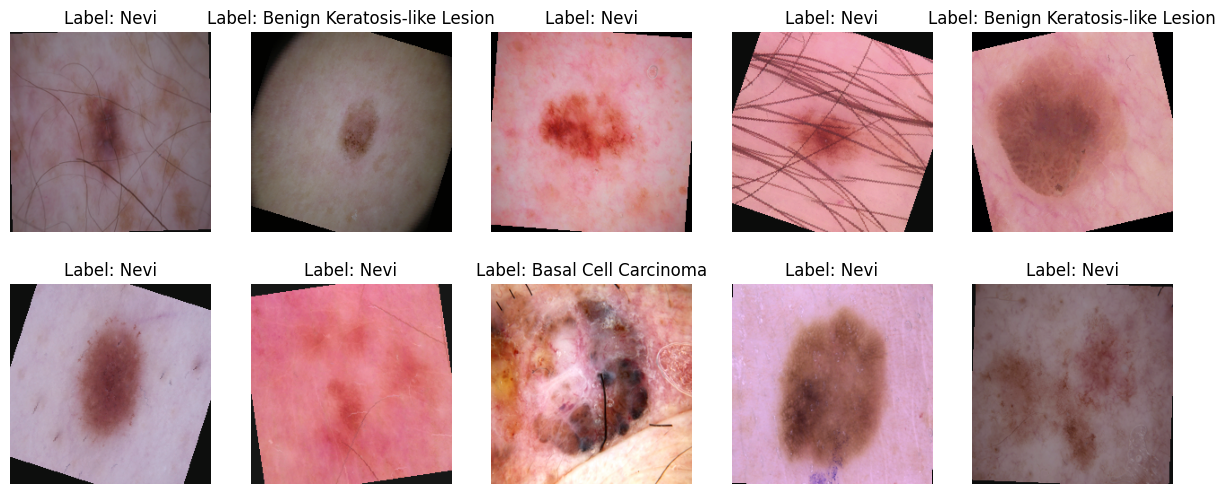

In [ ]:
def show_batch_images(dataloader):
    """Function to display a batch of images"""
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    full_class_names = {
        'mel': 'Melanoma',
        'bcc': 'Basal Cell Carcinoma',
        'akiec': 'Actinic Keratosis',
        'bkl': 'Benign Keratosis-like Lesion',
        'df': 'Dermatofibroma',
        'vasc': 'Vascular Lesion',
        'nv': 'Nevi'
    }

    label_names = [reverse_label_mapping[label] for label in labels.numpy()]
    full_class_names_list = [full_class_names[label] for label in label_names]

    for i in np.arange(10):
        image = images[i].numpy().transpose((1, 2, 0))
        image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)

        label_name = full_class_names_list[i]
        axes[i].set_title(f"Label: {label_name}")
        axes[i].axis('off')
    plt.show()

show_batch_images(train_dataloader)

In [ ]:
class ViTModel(nn.Module):
    def __init__(self, num_classes=7):
        super(ViTModel, self).__init__()
        self.model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        self.in_features = self.model.heads.head.in_features
        self.model.heads.head = nn.Linear(self.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTModel(num_classes=7).to(device)
print(model)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 114MB/s]


ViTModel(
  (model): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerN

In [ ]:
class ViTModel(nn.Module):
    def __init__(self, num_classes=7):
        super(ViTModel, self).__init__()
        self.model = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        self.model.heads.head = nn.Linear(self.model.heads.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTModel(num_classes=len(reverse_label_mapping)).to(device)

In [ ]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=10):
    scaler = amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 30)

        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        train_progress = tqdm(train_dataloader, desc="Training", unit="batch")

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)
            correct_train += (outputs.argmax(1) == labels).sum().item()
            total_train += labels.size(0)

            train_progress.set_postfix(loss=loss.item())

        scheduler.step()
        epoch_train_acc = correct_train / total_train * 100
        print(f"Train Accuracy: {epoch_train_acc:.2f}%\n")

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train_model(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=10)

<ipython-input-17-40b48a22af99>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Epoch 1/10
------------------------------


Training:   0%|          | 0/251 [00:00<?, ?batch/s]<ipython-input-17-40b48a22af99>:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
Training: 100%|██████████| 251/251 [02:13<00:00,  1.88batch/s, loss=0.407]


Train Accuracy: 74.73%

Epoch 2/10
------------------------------


Training: 100%|██████████| 251/251 [02:07<00:00,  1.96batch/s, loss=0.394]


Train Accuracy: 80.67%

Epoch 3/10
------------------------------


Training: 100%|██████████| 251/251 [02:05<00:00,  2.00batch/s, loss=0.536]


Train Accuracy: 82.94%

Epoch 4/10
------------------------------


Training: 100%|██████████| 251/251 [02:04<00:00,  2.02batch/s, loss=0.408]


Train Accuracy: 84.90%

Epoch 5/10
------------------------------


Training: 100%|██████████| 251/251 [02:08<00:00,  1.96batch/s, loss=0.394]


Train Accuracy: 87.68%

Epoch 6/10
------------------------------


Training: 100%|██████████| 251/251 [02:07<00:00,  1.96batch/s, loss=0.202]


Train Accuracy: 89.13%

Epoch 7/10
------------------------------


Training: 100%|██████████| 251/251 [02:03<00:00,  2.03batch/s, loss=0.221]


Train Accuracy: 90.46%

Epoch 8/10
------------------------------


Training: 100%|██████████| 251/251 [02:07<00:00,  1.97batch/s, loss=0.0388]


Train Accuracy: 95.09%

Epoch 9/10
------------------------------


Training: 100%|██████████| 251/251 [02:04<00:00,  2.01batch/s, loss=0.077]


Train Accuracy: 96.56%

Epoch 10/10
------------------------------


Training: 100%|██████████| 251/251 [02:07<00:00,  1.96batch/s, loss=0.246]

Train Accuracy: 97.79%



In [ ]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader, device):
    """Evaluate the model on the dataset."""
    model.eval()
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * correct_predictions / total_predictions
    print(f"Test Accuracy: {accuracy:.2f}%")

    return all_preds, all_labels, accuracy

In [ ]:
predictions, true_labels, accuracy = evaluate_model(model, val_dataloader, device)

class_names = train_dataset.label_encoder.classes_
report = classification_report(true_labels, predictions, target_names=class_names)
print("Classification Report:\n")
print(report)
print(f"Validation Accuracy: {accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 86.87%
Classification Report:

              precision    recall  f1-score   support

       akiec       0.64      0.68      0.66        65
         bcc       0.86      0.82      0.84       103
         bkl       0.86      0.69      0.77       220
          df       0.95      0.87      0.91        23
         mel       0.62      0.66      0.64       223
          nv       0.92      0.95      0.93      1341
        vasc       0.89      0.89      0.89        28

    accuracy                           0.87      2003
   macro avg       0.82      0.79      0.80      2003
weighted avg       0.87      0.87      0.87      2003

Validation Accuracy: 86.87%


In [ ]:
import matplotlib.pyplot as plt

def predict_single_image(model, image_path, transform, class_names, device):
    model.eval()
    img = Image.open(image_path).convert('RGB')
    img = ImageOps.exif_transpose(img)

    img_resized = img.resize((224, 224))
    input_img = transform(img_resized).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_img)
        pred = output.argmax(dim=1).item()

    predicted_class = class_names[pred]

    plt.imshow(img_resized)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

In [ ]:
from PIL import Image, ImageOps

In [ ]:
!wget -O /content/google_image.jpg "https://mohs-md.com/wp-content/uploads/2018/05/seborrheic-keratosis.jpg"

--2024-12-17 16:55:20--  https://mohs-md.com/wp-content/uploads/2018/05/seborrheic-keratosis.jpg
Resolving mohs-md.com (mohs-md.com)... 209.87.159.119
Connecting to mohs-md.com (mohs-md.com)|209.87.159.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93080 (91K) [image/jpeg]
Saving to: ‘/content/google_image.jpg’

/content/google_ima 100%[===================>]  90.90K   549KB/s    in 0.2s    

2024-12-17 16:55:21 (549 KB/s) - ‘/content/google_image.jpg’ saved [93080/93080]



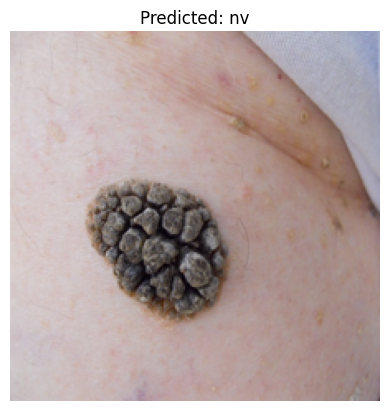

Predicted Label: nv


In [ ]:
image_path = "/content/google_image.jpg"
predicted_label = predict_single_image(model, image_path, transform, train_dataset.label_encoder.classes_, device)
print(f"Predicted Label: {predicted_label}")

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('/content/ham10000_dataset/HAM10000_metadata.csv')

In [ ]:
data['image_id']

,image_id
0,ISIC_0027419
1,ISIC_0025030
2,ISIC_0026769
3,ISIC_0025661
4,ISIC_0031633
...,...
10010,ISIC_0033084
10011,ISIC_0033550
10012,ISIC_0033536
10013,ISIC_0032854


In [ ]:
import torch
torch.save(model.state_dict(), 'ViTmodel.pth')
print("Model saved successfully!")

Model saved successfully!
